<a href="https://colab.research.google.com/github/alirempel/cap-comp215/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
import random

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [2]:
# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [4]:
def make_locations(n, m):
    """ Return list of (x, y) coordinates for all locations on n x m grid """
    return [(i, j) for i in range(n) for j in range(m)]

In [75]:
class Deer:
    """ Represent one deer object """
    max_weight=50
    initial_weight=20
    weight_gain=1
    weight_loss=1

    def __init__(self, loc=(0,0), weight=initial_weight):
        """Creates a new deer at the given location.

        loc: (x,y) tuple coordinate
        weight:
        """
        self.loc = tuple(loc)
        self.weight = weight

    @classmethod
    def make_deer(cls, num_deer, n):
        """ Factory: return a list Deer objects at random locations in n x m grid """
        # all (x,y) locations in an n x n grid...
        locations = make_locations(n, n)
        assert num_deer <= len(locations)  # verify pre-condition: there are enough locations for all deer
        # randomize the locations and construct the desired number of deer at random locations
        np.random.shuffle(locations)
        return [cls(locations[i]) for i in range(num_deer)]

    def visible_locations(self,x,y):
        """Return a list of (x,y) cell coordinates that are "visible" to the deer """
        neighbours = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        return neighbours

    def next_cell(self, env):
        """Picks neighbouring cell without deer.

        env: the grass area the deer lives in
        returns: tuple, coordinates of random neighbouring cell without deer
        """
        # find all empty, visible cells, "wrapping" vision around edges of environment
        visible_locs = env.wrap_locations( self.visible_locations(*self.loc) )
        print(visible_locs)
        empty_locs = env.get_empty_locations(visible_locs)
        return random.choices(empty_locs)[0]

    def step(self, env):
        """Look around, move, and graze.

        env: Environment object
        """
        self.loc = self.next_cell(env)
        # change (x,y) to row and col number
        row,col = env.state[self.loc[1]-1],env.state[self.loc[0]-1]

        if env.state[self.loc[1]-1][self.loc[0]-1]==env.OCCUPIED:
            self.weight += self.weight_gain
            env.graze(self.loc)
        else:
            self.weight -= self.weight_loss

    def is_starving(self):
        """Checks if weight has gone below 0."""
        return self.weight <= 0

In [76]:
class Environment:
    """Represents an environment with grazing deer."""

    EMPTY = 0
    OCCUPIED = 1

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    env_colour_map = matplotlib.colors.ListedColormap(cmap)

    def __init__(self, n, deers, p=.01,q=.5):
        """Initializes the attributes.

        n: number of rows and columns
        deers: iterable of deer, with random locations on (n, n) (used 'deers' because I needed some way to represent more than one deer)
        p: probability empty cell grows grass
        q: initial grass density (probability cell has grass (is occupied) in initial state)
        """
        assert(len(deers) <= n**2)  # can't have more deer than there are grid cells

        self.n = n
        self.deers = deers
        self.p = p
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        # keep track of which cells are unoccupied
        self.unoccupied = set(make_locations(n, n)) - set(deer.loc for deer in self.deers)


    def wrap_locations(self, locations):
        """ return listt of (x,y) locations, where each location is "wrapped" so it falls within the grid

        locations: iterable of 2-tuple (x,y) locations, some of which may fall outside grid dimensions
        """
        return [(x%self.n, y%self.n) for x,y in locations]

    def get_empty_locations(self, locations):
        """ select and return list locations that are unoccupied """
        return [loc for loc in locations if loc in self.unoccupied]

    def grow(self):
        """ grow grass in cells"""
        self.state[self.state == self.EMPTY] = np.random.choice([self.OCCUPIED,self.EMPTY], len(self.state[self.state==self.EMPTY]), 1, (self.p, 1-self.p))

    def graze(self, loc):
        """ remove grass from the given location """
        self.state[loc] = self.EMPTY

    def num_occupied(self):
        """ return the number of cells occupied by grass """
        return len(self.state[self.state == self.OCCUPIED])

    def pct_occupied(self):
        """ return the proportion of cells occupied by grass """
        return self.num_occupied() / self.state.size

    def step(self):
        """ Execute one time step. """
        # loop through the deers in random order
        for deer in np.random.permutation(self.deers):
            # mark the deer's cell unoccupied and allow them to "step" to new location
            self.unoccupied.add(deer.loc)
            deer.step(self)

            # if the deer is dead, remove from model
            if deer.is_starving():
                self.deers.remove(deer)
            else:
                # otherwise mark its new cell as occupied
                self.unoccupied.remove(deer.loc)

        # grow back some grass
        self.grow()
        return len(self.deers)

    def draw(self, axes=None, step=''):
        """Draws the environment with deer"""
        axes = axes or plt.gca()
        title = f'Time:{step} Deer population: {self.step()}%'
        plot_2d_array(self.state, axes=axes, title=title, cmap=self.env_colour_map, vmin=0, vmax=len(self.env_colour_map.colors))
        if self.deers:
            self._draw_deers()

    def _draw_deers(self):
        """ Draw the deers in centre of cell they occupy """
        # Transform from (col, row) to centre (x, y) of cell coordinate.
        rows, cols = np.transpose([deer.loc for deer in self.deers])
        xs = cols
        ys = rows
        plt.plot(xs, ys, '.', color='red')


[(6, 4), (8, 4), (7, 3), (7, 5)]


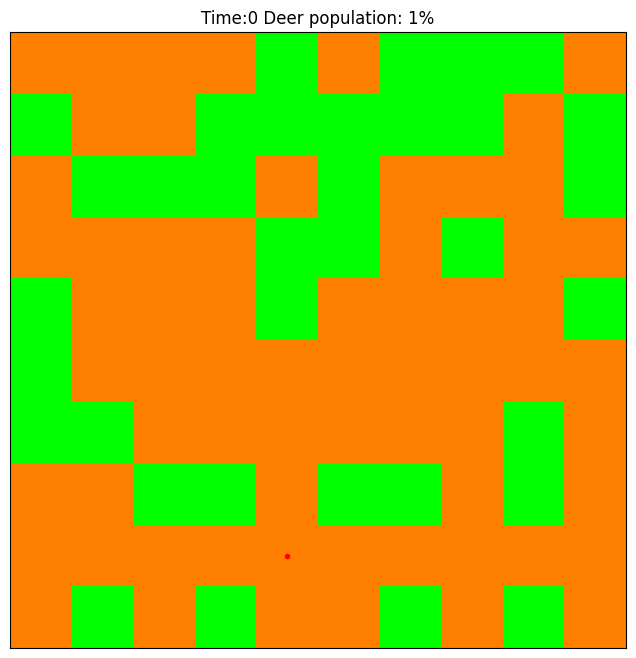

In [77]:
deer_list = Deer.make_deer(1,10)
deer_model = Environment(10,deer_list)
# print(deer_list[1].loc)
# print(deer_model.state)
# print(deer_model.state[deer_list[1].loc[1]-1][deer_list[1].loc[0]-1])
deer_animation = Animation2D(deer_model,frames=50)
deer_animation.animate(interval=1)